In [1]:
import torch_geometric
from torch_geometric.data import Data
import torch
from itertools import product, permutations
from math import factorial
import networkx as nx
from covering import *


# Procedure
In this notebook we generate a dataset of non isomorphic covering spaces of degree $k$ of a base graph $G$. By the Theorem of the paper, the resulting graphs are pairwise non-isomorphic.
We do so in 2 steps:
### Generate
Given a graph $G$ satisfying some conditions (connected, this will be relaxed), all neighbouring nodes are distinguishable by colour refinement, and it has Euler characteristic <0), and a parameter $k$, we generate all coverings of $G$ of degree $k$. 


In [2]:
edge_index = torch.tensor([[0, 1], [1, 0],
                          [1, 2], [2, 1],
                          [2, 3], [3, 2],
                          [2, 4], [4, 2],
                          [3, 4], [4, 3],
                          [4, 5], [5, 4],
                          [5, 6], [6, 5],
                          [5, 8], [8, 5],
                          [6, 7], [7, 6],
                          [6, 8], [8, 6]],
                          # [8, 9], [9, 8],
                          # [9, 10], [10, 9],
                          # [10, 11], [11, 10]]
                           dtype=torch.long)

# Distinguished edges (one per cycle) to make sampling more efficient
cycle_edge = [[2, 4], [5, 8]]

x = torch.tensor([[0], [0], [0], [0],
                  [0], [0], [0], [0],
                  [0]], dtype=torch.long)

data = Data(x=x, edge_index = edge_index.t().contiguous())

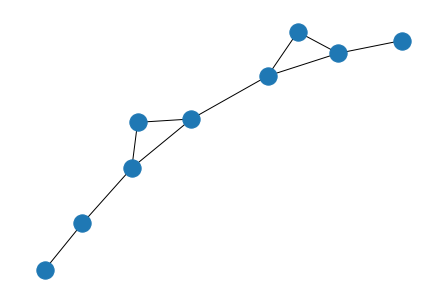

In [3]:
G = nx.Graph(edge_index.tolist())
nx.draw(G)

In [5]:
# faster version: 
L = generate_with_cycle_data(data, k=5, cycle_edge=cycle_edge, stop=20)
G1 = nx.Graph(L[0][0].edge_index.t().tolist())
G2 = nx.Graph(L[1][0].edge_index.t().tolist())
G3 = nx.Graph(L[2][0].edge_index.t().tolist())
print("total number of non-isomorphic degree 5 covers: ", len(L))

total number of covers to check:  14400
we found  20 ! Only in  872  tries!
total number of non-isomorphic degree 5 covers:  20


In [20]:
Lp = [get_colour_signal(l[0], l[1], l[2]) for l in L]

nb of nodes:  45
nb od edges:  50


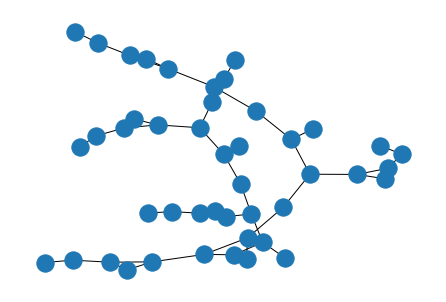

In [70]:
nx.draw(G1)
print("nb of nodes: ", len(G1.nodes))
print("nb od edges: ", len(G1.edges))

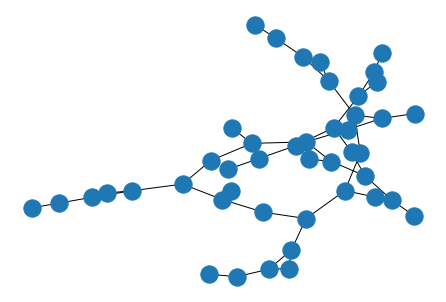

In [8]:
nx.draw(G2)

## Load dataset

In [37]:
# # save data set:
# len(L)
# dataset = [cover[0] for cover in L]
# # for i, data in enumerate(dataset):
# #     data.y = torch.tensor([i], dtype = torch.long)
# #     data.x = torch.ones((45, 1))
# edge_indices = torch.cat([data.edge_index.unsqueeze(0) for data in dataset])
# torch.save(edge_indices, "edge_indices_deg5.pt")

In [5]:
# load the data:
edge_indices = torch.load("deg5_withcolouring.pt")
data_list = []
for i, edge_index in enumerate(edge_indices):
    data = Data(x = torch.ones((45, 1)), edge_index=edge_index, y = torch.tensor([i], dtype=torch.long))
    data_list.append(data)
    
print(data_list[60].y)
print(len(data_list))
print(data_list[5])

tensor([60])
97
Data(x=[45, 1], edge_index=[2, 100], y=[1])


In [6]:
# just make three classes:
for i, data in enumerate(data_list):
    if i%3==0:
        data.y = torch.tensor([0], dtype=torch.long)
    if i%3==1:
        data.y = torch.tensor([1], dtype=torch.long)
    if i%3==2:
        data.y = torch.tensor([2], dtype=torch.long)

In [7]:
# lets try out our method only on 3 nonisomorphic graphs (that are deg 5)...
small_list = [data_list[0], data_list[1], data_list[2]]
small_list[0].y, small_list[1].y, small_list[2].y

(tensor([0]), tensor([1]), tensor([2]))

# GNNs

In [8]:
# now lets get learning!!!
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GINConv, GATConv, ChebConv
from torch_geometric.nn import Linear as Linear_pyg
# from torch_geometric.nn.glob.glob import global_mean_pool as gmp

# num_classes = len(data_list)
# print(num_classes)

class SIMPLE(torch.nn.Module):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__()
        self.conv1 = None
        self.conv2 = None
        self.fc = torch.nn.Linear(2*hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        
        emb1 = x.mean(dim=0, keepdim=True)
        emb2 = torch.max(x, dim=0, keepdim=True).values
        emb = torch.cat((emb1, emb2), dim=1)
        x = self.fc(emb)

        return F.softmax(x, dim=1), emb

class GCN(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
    
class SAGE(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)

class GAT(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = GATConv(in_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)

class GIN(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = GINConv(nn=Linear_pyg(in_dim, hidden_dim))
        self.conv2 = GINConv(nn=Linear_pyg(hidden_dim, hidden_dim))
        
class CHEB(SIMPLE):
    def __init__(self, in_dim=16, hidden_dim=16, num_classes=97):
        super().__init__(in_dim, hidden_dim, num_classes)
        self.conv1 = ChebConv(in_dim, hidden_dim, K=1)
        self.conv2 = ChebConv(hidden_dim, hidden_dim, K=1)

In [9]:
def train_model(model, data_list):
    cross_entropy = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(400):
        for data in data_list:
            optimizer.zero_grad()
            out, emb = model(data)
            loss = cross_entropy(out, data.y)
            loss.backward()
            optimizer.step()
        if epoch%150==0:
            print("loss: ", loss)
            print(out.sum(), emb.sum())


def eval_model(model, data_list):
    model.eval()
    preds = [model(data)[0].argmax(dim=1) for data in data_list]
    correct = sum([1 if preds[i]==data_list[i].y else 0 for i in range(len(data_list))])
    acc = int(correct) / len(data_list)
    print(f'Train accuracy: {acc:.4f}')

    # bool = torch.equal(model(data_list[0])[1], model(data_list[1])[1]) and torch.equal(model(data_list[0])[1], model(data_list[2])[1])
    bool = torch.equal(model(data_list[0])[1].repeat((len(data_list), 1)), torch.stack([model(data_list[i])[1][0] for i in range(len(data_list))] ))
    print("All embeddings are all equal: ", bool)
    if bool:
        print("All predictions are: ", model(data_list[0])[0].argmax(dim=1))


In [10]:
def whole_analysis(data_list, in_dim=16, hidden_dim=16, num_classes=97):
    print("GCN: ")
    print("")
    model = GCN(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)

    print("")
    print("GAT")
    print("")
    model = GAT(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)

    print("")
    print("GIN: ")
    print("")
    model = GIN(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)

    print("")
    print("SAGE: ")
    print("")
    model = SAGE(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)
    
    print("")
    print("Cheb: ")
    print("")
    model = CHEB(in_dim, hidden_dim, num_classes)
    train_model(model, data_list)
    eval_model(model, data_list)


## constant signal

In [50]:
for data in small_list:
    data.x = torch.ones((data.x.shape[0], 1))
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, 1, 100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.1717, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(8.0517, grad_fn=<SumBackward0>)
loss:  tensor(1.1037, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0064, grad_fn=<SumBackward0>)
loss:  tensor(1.1004, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  True
All predictions are:  tensor([0])

GAT

loss:  tensor(1.1578, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(6.8361, grad_fn=<SumBackward0>)
loss:  tensor(1.0970, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0008, grad_fn=<SumBackward0>)
loss:  tensor(1.0982, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(6.1480e-05, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  True
All predictions are:  tensor([2])

GIN: 

loss:  tenso

## Degree signal

In [17]:
from torch_geometric.utils import degree
for data in data_list:
    data.x = degree(data.edge_index[0]).unsqueeze(1)
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=1, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.2538, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(20.8969, grad_fn=<SumBackward0>)
loss:  tensor(1.0994, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0529, grad_fn=<SumBackward0>)
loss:  tensor(1.0990, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0135, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  True
All predictions are:  tensor([1])

GAT

loss:  tensor(1.2776, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(21.9648, grad_fn=<SumBackward0>)
loss:  tensor(1.0988, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(0.0516, grad_fn=<SumBackward0>)
loss:  tensor(1.0988, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(0.0287, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  True
All predictions are:  tensor([1])

GIN: 

loss:  ten

## Random normal signal

In [12]:
for data in small_list:
    data.x = torch.normal(mean = 0, std = torch.ones(45, 1))
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=1, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.2288, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(13.3182, grad_fn=<SumBackward0>)
loss:  tensor(0.5529, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(223.7640, grad_fn=<SumBackward0>)
loss:  tensor(0.5525, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(197.5469, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GAT

loss:  tensor(1.2368, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(13.2937, grad_fn=<SumBackward0>)
loss:  tensor(0.5522, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(186.8474, grad_fn=<SumBackward0>)
loss:  tensor(0.5520, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(174.7480, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GIN: 

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad

## Random uniform

In [ ]:
for data in small_list:
    data.x = torch.rand(size=data.x.shape)
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=1, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.1609, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(5.6607, grad_fn=<SumBackward0>)
loss:  tensor(0.8342, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(126.7008, grad_fn=<SumBackward0>)
loss:  tensor(0.8101, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(260.4312, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GAT

loss:  tensor(1.1509, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(6.6010, grad_fn=<SumBackward0>)
loss:  tensor(0.6523, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(45.0819, grad_fn=<SumBackward0>)
loss:  tensor(0.5586, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(67.1575, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GIN: 

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<Sum

## Unique Identifiers:
each of the node of a graph gets a unique identifier.

In [ ]:
for data in small_list:
    temp = torch.zeros((45, 45))
    for i in range(45): # one per node
        temp[i, i] = 1
    data.x = temp
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=45, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(1807.9285, grad_fn=<SumBackward0>)
loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(325.2245, grad_fn=<SumBackward0>)
loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(165.9739, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  False

GAT

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(1825.8007, grad_fn=<SumBackward0>)
loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(476.0897, grad_fn=<SumBackward0>)
loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(124.4833, grad_fn=<SumBackward0>)
Train accuracy: 0.3333
All embeddings are all equal:  False

GIN: 

loss:  tensor(0.5514, grad_fn=<NllLossBackward>)
tensor(1., 

## y as the signal

In [26]:
from torch_geometric.utils import degree
for data in small_list:
    data.x = data.y.float().repeat((45, 1))
print("signal dimension: ", data.x.shape)
whole_analysis(small_list, in_dim=1, hidden_dim=100, num_classes=3)

signal dimension:  torch.Size([45, 1])
GCN: 

loss:  tensor(1.1574, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(16.2284, grad_fn=<SumBackward0>)
loss:  tensor(0.5520, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(79.4581, grad_fn=<SumBackward0>)
loss:  tensor(0.5519, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(77.2605, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GAT

loss:  tensor(1.1405, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(14.7141, grad_fn=<SumBackward0>)
loss:  tensor(0.5520, grad_fn=<NllLossBackward>)
tensor(1., grad_fn=<SumBackward0>) tensor(78.1413, grad_fn=<SumBackward0>)
loss:  tensor(0.5519, grad_fn=<NllLossBackward>)
tensor(1.0000, grad_fn=<SumBackward0>) tensor(75.7573, grad_fn=<SumBackward0>)
Train accuracy: 1.0000
All embeddings are all equal:  False

GIN: 

loss:  tensor(1.5514, grad_fn=<NllLossBackward>)
tensor(1., grad

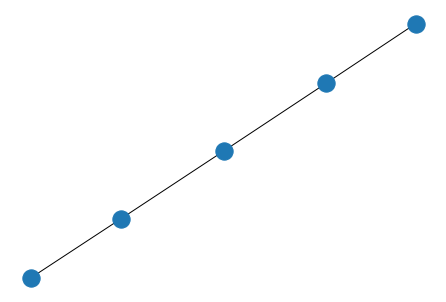

In [46]:
###  Testing the extends function
cycle_graph = nx.Graph([[0, 1], [1, 2], [2, 0]])
v_graph = nx.Graph([[0, 1], [1, 2], [0, 3], [3, 4]])

cycle_node_map = {0:0, 1:1, 2:2}
cycle_node_type = {0: {0}, 1: {1}, 2: {2}}
v_node_map = {0:0, 1:1, 2:2, 3:2, 4:1}
v_node_type = {0: {0}, 1: {1, 4}, 2: {2, 3}}
nx.draw(cycle graph)
nx.draw(v_graph)

In [ ]:
print("should be false: ", extends(cycle_graph, v_graph, 0,
        cycle_node_map, cycle_node_type,
        v_node_map, v_node_type))
print("")
print("should be true: ", extends(cycle_graph, cycle_graph, 0,
        cycle_node_map, cycle_node_type,
        cycle_node_map, cycle_node_type))
print("should be true: ", extends(v_graph, cycle_graph, 0,
        cycle_node_map, cycle_node_type,
        cycle_node_map, cycle_node_type))

## Weisfeiler Leman:

In [6]:
#from networkx import weisfeiler_lehman_graph_hash
from networkx import weisfeiler_lehman_graph_hash
hashes = set()
for i, data in enumerate(data_list):
    index = data.edge_index.transpose(0, 1).numpy()
    G = nx.Graph(index.tolist())
    hsh = nx.weisfeiler_lehman_graph_hash(G, iterations=12)
    if i % 5:
        print(i)
    if not hsh in hashes:
        print("new hash!")
        hashes.add(hsh)

NameError: name 'data_list' is not defined